In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability
from funcs.helper import calculate_inclination

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [2]:
#tstamp = '13_12_2019_10_18'
tstamp

'30_01_2020_15_57'

In [3]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
#guesses = pd.read_csv(f"{CWD}/archive/eyeball_results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)


In [4]:
#lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [24]:

lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[5]
i_mu, i_sigma = calculate_inclination(target)
i_mu, i_sigma = i_mu.to("rad").value, i_sigma.to("rad").value
target

ID                    230120143
QCS                          16
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                  generic
h_mission                  TESS
SpT                          M7
view_start                 1741
view_stop                  1743
view_min                   2320
view_max                   2500
BJDoff                  2457000
tstart                  1741.62
ampl_min                    1.5
ampl_max                    2.5
RA                      250.086
Dec                     67.6013
J                         9.854
R                           NaN
Gaia_G                   13.557
vsini_kms                  10.8
e_vsini_kms                 0.7
Prot_d                 0.378325
sini                  0.6844128
Ref                Kesseli+2018
identifier                  NaN
Rstar                       NaN
idtyp                      tess
id                    230120143
st      

5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 230120143 modulation period:  9.089056409968848 h
Relative amplitude of modulation: -3.7e-03
[1738.65173791 1738.6531268  1738.65451569 ... 1763.31571967 1763.31710857
 1763.31849747]
[11.266142 11.266142 11.266142 ... 11.266142 11.266142 11.266142]


2352.491108184261

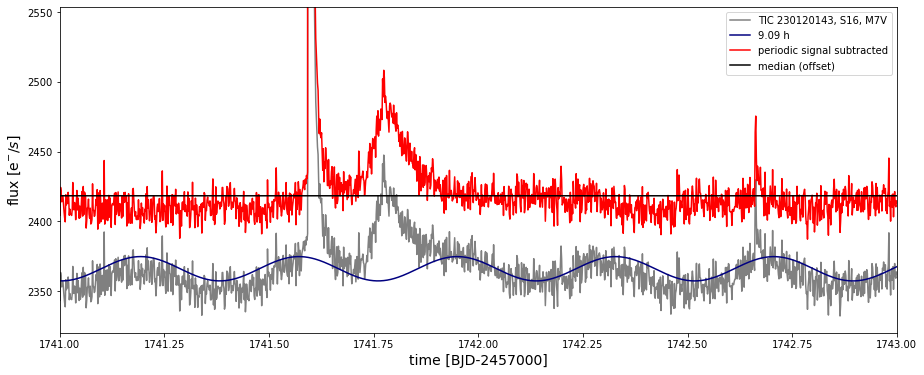

In [25]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
#from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False,)# cut=[target.view_start-5,target.view_stop+5])
print(t)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = F#refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                    # std_rolling_window_length=15, pad=25)

choice = (t > target.view_start ) & (t < target.view_stop) # only one flare in TIC 237 : + 1.56 - 1.
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med-10)
phi = (t - t[0])/target.Prot_d * 2 * np.pi

pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

1440

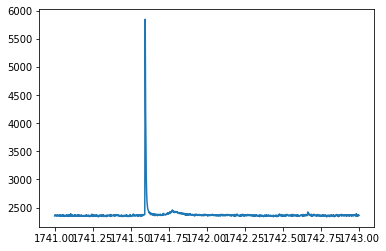

In [26]:
plt.plot(t,flux)
len(t)

In [47]:
i_mu*180/np.pi, i_sigma

(24.02478912140365, 0.03171026257969871)

In [27]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median

2352.491108184261

(2300, 3500)

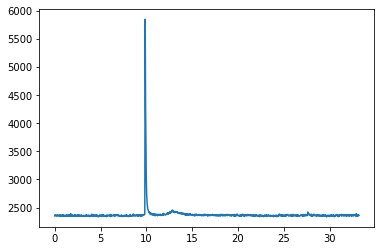

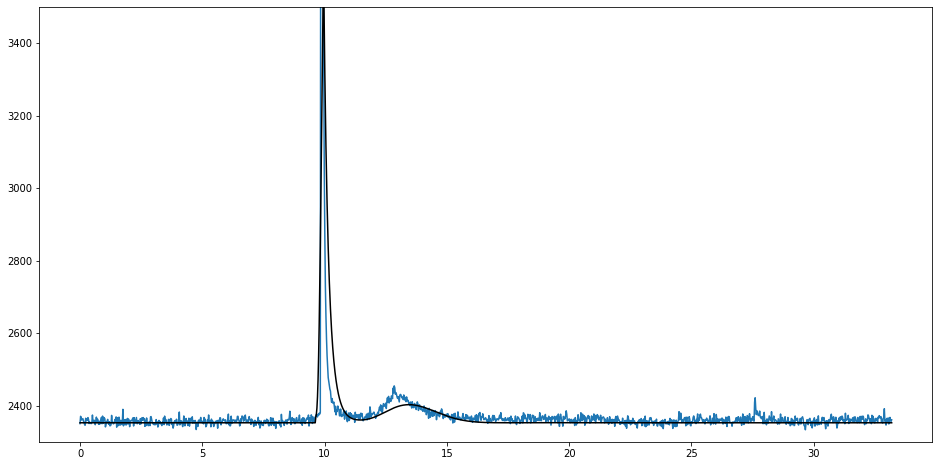

In [96]:

phi_a = (target.tstart- t[0]-.025)/target.Prot_d * 2 * np.pi
theta_a = -22*np.pi/180#target.theta_a_init
a = 10
fwhm =  .04/target.Prot_d * 2 * np.pi
#i_mu = target.incl
#i_sigma = target.incl_err
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 0 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(phi,flux)
# for i in range(-10,120,5):
#     plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i * np.pi / 180,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=110 * np.pi / 180,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(2300,3500)

### Save inits

In [ ]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
   # f.write(firstout)
    f.write(out)

## Run MCMC

In [ ]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [ ]:
tstamp, filename

In [ ]:

sampler.run_mcmc(pos, 50000, progress=True, store=True);

In [ ]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

In [ ]:
tstamp, target.ID

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))

In [ ]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED